# TAT-C Interface Implementation

Specifies a function with well-defined input (`PropagationRequest`) and output (`PropagationResponse`) using TAT-C's implementation.

In [1]:
from tatc.schemas import Instrument, Satellite, TwoLineElements
from tatc.analysis import collect_orbit_track, OrbitCoordinate, OrbitOutput

from eose.propagation import PropagationRecord, PropagationRequest, PropagationResponse
from eose.orbits import GeneralPerturbationsOrbitState
from eose.utils import CartesianReferenceFrame, FixedOrientation

import pandas as pd


def propagate_tatc(request: PropagationRequest) -> PropagationResponse:
    return PropagationResponse(
        records=collect_orbit_track(
            Satellite(
                name=request.orbit.object_name,
                orbit=TwoLineElements(tle=request.orbit.to_tle()),
            ),
            Instrument(name="Instrument"),
            pd.date_range(
                request.start, request.start + request.duration, freq=request.time_step
            ),
            coordinates=(
                OrbitCoordinate.ECI
                if request.frame == CartesianReferenceFrame.ICRF
                else OrbitCoordinate.ECEF
            ),
            orbit_output=OrbitOutput.POSITION_VELOCITY,
        ).apply(
            lambda r: PropagationRecord(
                time=r.time,
                frame=request.frame,
                position=r.geometry.coords[0],
                velocity=r.velocity.coords[0],
                body_orientation=FixedOrientation.NADIR_GEOCENTRIC,
            ),
            axis=1,
        ),
    )

# Example

Pulls OMM file from Celestrak, issues propagation request starting Jan 1 2024 for 1 hour (1 minute time step), and displays results.

In [2]:
import json
from datetime import datetime, timedelta, timezone

# note: celestrak request is rate-limited; using hard-coded version
# import requests
# response = requests.get("https://celestrak.org/NORAD/elements/gp.php?NAME=ZARYA&FORMAT=JSON").content
response = '[{"OBJECT_NAME":"ISS (ZARYA)","OBJECT_ID":"1998-067A","EPOCH":"2024-06-07T09:53:34.728000","MEAN_MOTION":15.50975122,"ECCENTRICITY":0.0005669,"INCLINATION":51.6419,"RA_OF_ASC_NODE":3.7199,"ARG_OF_PERICENTER":284.672,"MEAN_ANOMALY":139.0837,"EPHEMERIS_TYPE":0,"CLASSIFICATION_TYPE":"U","NORAD_CAT_ID":25544,"ELEMENT_SET_NO":999,"REV_AT_EPOCH":45703,"BSTAR":0.00033759,"MEAN_MOTION_DOT":0.00019541,"MEAN_MOTION_DDOT":0}]'
iss_omm = json.loads(response)[0]

In [3]:
request = PropagationRequest(
    orbit=GeneralPerturbationsOrbitState.from_omm(iss_omm),
    start=datetime(2024, 1, 1, tzinfo=timezone.utc),
    duration=timedelta(hours=1),
    time_step=timedelta(minutes=1),
    frame=CartesianReferenceFrame.ICRF,
)

display(request.model_dump_json())

response = propagate_tatc(request)

display(response.model_dump_json())

data = response.as_dataframe()

display(data)

'{"orbit":{"object_name":"ISS (ZARYA)","object_id":"1998-067A","epoch":"2024-06-07T09:53:34.728000","mean_motion":15.50975122,"eccentricity":0.0005669,"inclination":51.6419,"ra_of_asc_node":3.7199,"arg_of_pericenter":284.672,"mean_anomaly":139.0837,"ephemeris_type":0,"classification_type":"U","norad_cat_id":25544,"element_set_no":999,"rev_at_epoch":45703,"bstar":0.00033759,"mean_motion_dot":0.00019541,"mean_motion_ddot":0.0},"start":"2024-01-01T00:00:00Z","duration":"PT1H","time_step":"PT1M","frame":"ICRF"}'

'{"records":[{"frame":"ICRF","time":"2024-01-01T00:00:00Z","position":[-4499686.1202688,-232613.21550674032,5091657.311614182],"velocity":[-1677.6634157866658,-7252.659671818871,-1804.8077999287968],"body_orientation":"NADIR_GEOCENTRIC","view_orientation":[0.0,0.0,0.0,1.0]},{"frame":"ICRF","time":"2024-01-01T00:01:00Z","position":[-4590028.087700935,-666915.9700864203,4971828.475405545],"velocity":[-1332.576798616102,-7218.509492576277,-2187.9548996394055],"body_orientation":"NADIR_GEOCENTRIC","view_orientation":[0.0,0.0,0.0,1.0]},{"frame":"ICRF","time":"2024-01-01T00:02:00Z","position":[-4659474.854577173,-1098182.798715333,4829301.789743175],"velocity":[-981.4248032269486,-7151.498310442072,-2561.1120354711065],"body_orientation":"NADIR_GEOCENTRIC","view_orientation":[0.0,0.0,0.0,1.0]},{"frame":"ICRF","time":"2024-01-01T00:03:00Z","position":[-4707710.266126301,-1524450.4281797595,4664727.924286884],"velocity":[-625.8040584505683,-7051.930817092405,-2922.5776733547577],"body_orientat

,geometry,frame,time,position,velocity,body_orientation,view_orientation
0,POINT Z (83.10851 48.53978 432820.67293),ICRF,2024-01-01 00:00:00+00:00,"[-4499686.1202688, -232613.21550674032, 509165...","[-1677.6634157866658, -7252.659671818871, -180...",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"
1,POINT Z (88.15274 47.03603 432699.62950),ICRF,2024-01-01 00:01:00+00:00,"[-4590028.087700935, -666915.9700864203, 49718...","[-1332.576798616102, -7218.509492576277, -2187...",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"
2,POINT Z (92.88653 45.30148 432541.96420),ICRF,2024-01-01 00:02:00+00:00,"[-4659474.854577173, -1098182.798715333, 48293...","[-981.4248032269486, -7151.498310442072, -2561...",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"
3,POINT Z (97.30894 43.36259 432355.86862),ICRF,2024-01-01 00:03:00+00:00,"[-4707710.266126301, -1524450.4281797595, 4664...","[-625.8040584505683, -7051.930817092405, -2922...",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"
4,POINT Z (101.43038 41.24458 432150.55101),ICRF,2024-01-01 00:04:00+00:00,"[-4734514.636033979, -1943778.3089340634, 4478...","[-267.3323844160795, -6920.2597150227775, -327...",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"
...,...,...,...,...,...,...,...
56,POINT Z (-72.57352 -27.71768 439366.32380),ICRF,2024-01-01 00:56:00+00:00,"[4529073.767911281, 3986627.0695678387, -31638...","[-1629.2524710910448, 5685.3328931624, 4849.06...",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"
57,POINT Z (-69.84962 -24.91917 438039.85643),ICRF,2024-01-01 00:57:00+00:00,"[4421118.990028289, 4318448.275739423, -286593...","[-1967.880213649685, 5371.110358027979, 5077.8...",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"
58,POINT Z (-67.25735 -22.06222 436740.62396),ICRF,2024-01-01 00:58:00+00:00,"[4293101.719886929, 4630672.72570865, -2554970...","[-2297.742415388213, 5032.3537458145065, 5283....",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"
59,POINT Z (-64.77708 -19.15611 435483.56620),ICRF,2024-01-01 00:59:00+00:00,"[4145593.370171102, 4921873.335961587, -223237...","[-2617.3294734951587, 4670.580692719185, 5465....",NADIR_GEOCENTRIC,"[0, 0, 0, 1]"


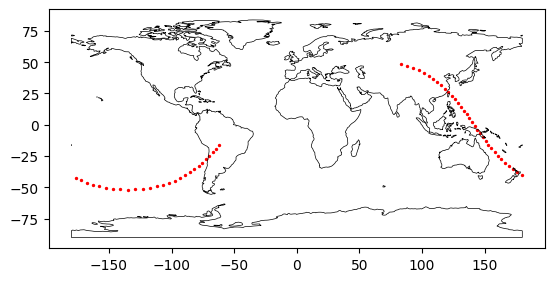

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd

# load shapefile
world = gpd.read_file(
    "https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip"
)

# example composite plot using GeoDataFrames
fig, ax = plt.subplots()
data.plot(ax=ax, markersize=2, color="r")
world.boundary.plot(ax=ax, lw=0.5, color="k")
ax.set_aspect("equal")
plt.show()